In [4]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("fmena14/volcanoesvenus")
files = os.listdir(path)

print("Path:", path)
print(files)

Path: /Users/gabrieledurante/.cache/kagglehub/datasets/fmena14/volcanoesvenus/versions/1
['Volcanoes_train', 'Volcanoes_test']


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

X_train = pd.read_csv(os.path.join(path, 'volcanoes_train', 'train_images.csv'))
y_train = pd.read_csv(os.path.join(path, 'volcanoes_train', 'train_labels.csv'))
X_test = pd.read_csv(os.path.join(path, 'volcanoes_test', 'test_images.csv'))
y_test = pd.read_csv(os.path.join(path, 'volcanoes_test', 'test_labels.csv'))

def XFix(X):
    X.loc[-1] = X.columns.values.astype(float).astype(int)  # adding column names as a new row
    X.index = X.index + 1  # shifting index
    X.sort_index(inplace=True)  # sorting the index

XFix(X_train)
XFix(X_test)

y_train = y_train["Volcano?"]
y_test = y_test["Volcano?"]

X_train = X_train.values.astype(np.float32)
y_train = y_train.values.astype(np.int64)
X_test = X_test.values.astype(np.float32)
y_test = y_test.values.astype(np.int64)

# Normalize pixel values to [0, 1]
X_train /= 255.0
X_test /= 255.0

y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [7]:
print("X_train shape:\t",X_train.shape,"\ny_train shape:\t",y_train.shape,"\nX_test shape:\t",X_test.shape,"\ny_test shape:\t",y_test.shape)

X_train shape:	 (7000, 12100) 
y_train shape:	 (7000, 4) 
X_test shape:	 (2734, 12100) 
y_test shape:	 (2734, 4)


In [11]:
# import torchvision
# from torchvision import transforms
# in this case, we dont have to transform images in tensor because we have images in csv

import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class VolcanoDataset(Dataset):
   def __init__ (self, images, labels):
      self.images = torch.tensor(images, dtype = torch.float64)
      self.labels = torch.tensor(labels, dtype = torch.float64)
      
   def __len__(self):
      return len(self.images)
   
   def __getitem__(self, idx):
      return self.images[idx], self.labels[idx]

train_dataset = VolcanoDataset(X_train, y_train)
test_dataset = VolcanoDataset(X_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# NN model
import torch.nn as nn

hidden_units = [64, 32]
input_size = X_train.shape[1] # 12100 (110x110)
output_size = len(np.unique(y_train))

all_layers = []
for hidden_unit in hidden_units:
   all_layers.append(nn.Linear(input_size, hidden_unit))
   all_layers.append(nn.ReLU())
   input_size = hidden_unit # Update input_size for the next layer
   
all_layers.append(nn.Linear(hidden_units[-1], output_size))  # Final layer

model = nn.Sequential(*all_layers)
print(model)

Sequential(
  (0): Linear(in_features=12100, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=2, bias=True)
)


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
torch.manual_seed(1)

def train_model(model, train_loader, epochs=25, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in train_loader:
            images = images.to(device).float()  # Ensure images are float32 and on the correct device
            labels = labels.to(device).long()  # Ensure labels are long and on the correct device

            # Convert one-hot encoded labels to class indices
            if labels.dim() == 2:  # Check if labels are one-hot encoded
                labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()

            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    accuracy = correct_preds / total_preds
    print(f'Accuracy: {accuracy:.4f}')

train_model(model, train_loader)

Epoch 1/25, Loss: 0.4313, Accuracy: 0.8571
Epoch 2/25, Loss: 0.4033, Accuracy: 0.8571
Epoch 3/25, Loss: 0.4062, Accuracy: 0.8571
Epoch 4/25, Loss: 0.3897, Accuracy: 0.8571
Epoch 5/25, Loss: 0.3785, Accuracy: 0.8571
Epoch 6/25, Loss: 0.3640, Accuracy: 0.8571
Epoch 7/25, Loss: 0.3331, Accuracy: 0.8571
Epoch 8/25, Loss: 0.3282, Accuracy: 0.8693
Epoch 9/25, Loss: 0.3061, Accuracy: 0.8839
Epoch 10/25, Loss: 0.2739, Accuracy: 0.9006
Epoch 11/25, Loss: 0.2595, Accuracy: 0.9063
Epoch 12/25, Loss: 0.2450, Accuracy: 0.9086
Epoch 13/25, Loss: 0.2484, Accuracy: 0.9093
Epoch 14/25, Loss: 0.2384, Accuracy: 0.9170
Epoch 15/25, Loss: 0.2467, Accuracy: 0.9113
Epoch 16/25, Loss: 0.2219, Accuracy: 0.9234
Epoch 17/25, Loss: 0.2432, Accuracy: 0.9127
Epoch 18/25, Loss: 0.2188, Accuracy: 0.9210
Epoch 19/25, Loss: 0.2055, Accuracy: 0.9270
Epoch 20/25, Loss: 0.2165, Accuracy: 0.9251
Epoch 21/25, Loss: 0.2205, Accuracy: 0.9244
Epoch 22/25, Loss: 0.2085, Accuracy: 0.9246
Epoch 23/25, Loss: 0.2041, Accuracy: 0.92

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming model, train_loader, and test_loader are already defined
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.manual_seed(1)

def train_model(model, train_loader, test_loader, epochs=25, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device).long()

            if labels.dim() == 2:  # Check if labels are one-hot encoded
                labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_accuracy)

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct_test_preds = 0
        total_test_preds = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device).float()
                labels = labels.to(device).long()

                if labels.dim() == 2:
                    labels = torch.argmax(labels, dim=1)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_test_preds += (predicted == labels).sum().item()
                total_test_preds += labels.size(0)

        test_loss /= len(test_loader)
        test_accuracy = correct_test_preds / total_test_preds
        test_loss_list.append(test_loss)
        test_acc_list.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
    
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

def plot_metrics(train_loss_list, train_acc_list, test_loss_list, test_acc_list, epochs):
    # Plotting
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs + 1), train_loss_list, label="Train Loss", color='blue', linewidth=3)
    plt.plot(range(1, epochs + 1), test_loss_list, label="Test Loss", color='orange', linestyle='--', linewidth=3)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    # plt.title("Loss vs. Epochs")
    plt.legend(fontsize=15)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs + 1), train_acc_list, label="Train Accuracy", color='blue', linewidth=3)
    plt.plot(range(1, epochs + 1), test_acc_list, label="Test Accuracy", color='orange', linestyle='--', linewidth=3)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    # plt.title("Accuracy vs. Epochs")
    plt.legend(fontsize=15)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'images/NN_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
train_loss, train_acc, test_loss, test_acc = train_model(model, train_loader, test_loader, epochs=25)

Epoch 1/25, Train Loss: 0.1169, Train Acc: 0.9657, Test Loss: 0.2595, Test Acc: 0.9151
Epoch 2/25, Train Loss: 0.1008, Train Acc: 0.9719, Test Loss: 0.2091, Test Acc: 0.9323
Epoch 3/25, Train Loss: 0.1287, Train Acc: 0.9654, Test Loss: 0.2264, Test Acc: 0.9294
Epoch 4/25, Train Loss: 0.1186, Train Acc: 0.9656, Test Loss: 0.2232, Test Acc: 0.9301
Epoch 5/25, Train Loss: 0.1089, Train Acc: 0.9679, Test Loss: 0.2452, Test Acc: 0.9236
Epoch 6/25, Train Loss: 0.1409, Train Acc: 0.9596, Test Loss: 0.2036, Test Acc: 0.9327
Epoch 7/25, Train Loss: 0.0930, Train Acc: 0.9753, Test Loss: 0.2248, Test Acc: 0.9305
Epoch 8/25, Train Loss: 0.1255, Train Acc: 0.9617, Test Loss: 0.3564, Test Acc: 0.8749
Epoch 9/25, Train Loss: 0.0964, Train Acc: 0.9740, Test Loss: 0.2140, Test Acc: 0.9312
Epoch 10/25, Train Loss: 0.1408, Train Acc: 0.9580, Test Loss: 0.6643, Test Acc: 0.8548
Epoch 11/25, Train Loss: 0.2007, Train Acc: 0.9480, Test Loss: 0.2177, Test Acc: 0.9301
Epoch 12/25, Train Loss: 0.1176, Train Ac

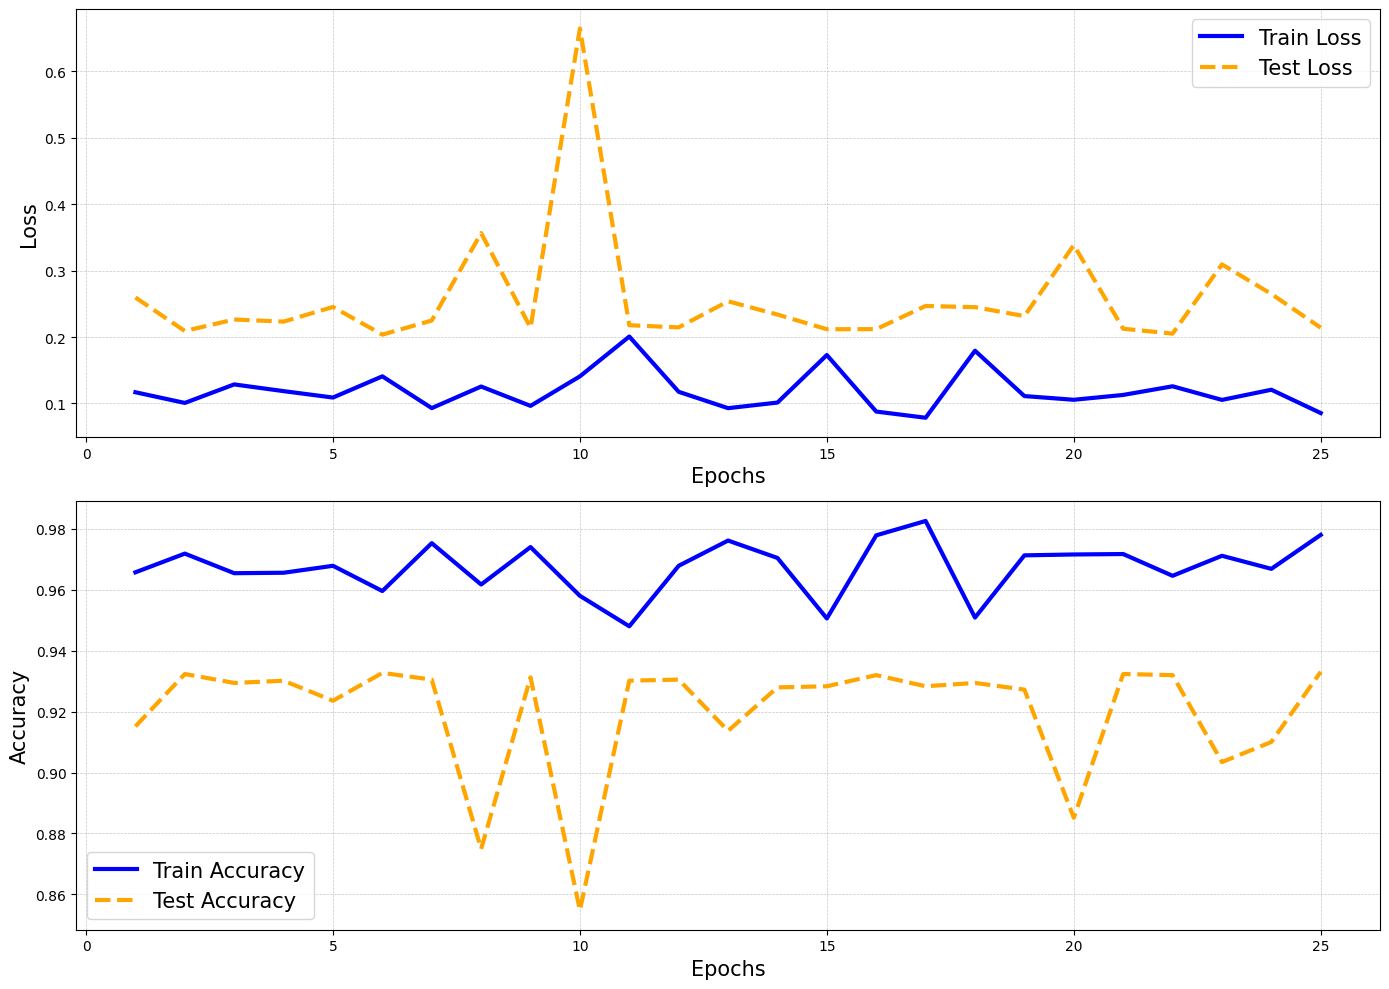

In [41]:
plot_metrics(train_loss, train_acc, test_loss, test_acc, epochs=25)

In [ ]:
# BCEWithLogitsLoss for binary classification
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.manual_seed(1)

def train_model(model, train_loader, epochs=25, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0

        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device).float()

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid and threshold at 0.5
            correct_preds += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = (correct_preds / len(train_loader.dataset)) -1   # Calculate accuracy as fraction of total dataset
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    accuracy = (correct_preds / len(train_loader.dataset)) - 1
    print(f'Accuracy: {accuracy:.4f}')

train_model(model, train_loader)

Epoch 1/25, Loss: 0.0820, Accuracy: 0.9533
Epoch 2/25, Loss: 0.0837, Accuracy: 0.9580
Epoch 3/25, Loss: 0.1341, Accuracy: 0.9206
Epoch 4/25, Loss: 0.0633, Accuracy: 0.9689
Epoch 5/25, Loss: 0.2527, Accuracy: 0.8491
Epoch 6/25, Loss: 0.1258, Accuracy: 0.9239
Epoch 7/25, Loss: 0.0821, Accuracy: 0.9526
Epoch 8/25, Loss: 0.0714, Accuracy: 0.9671
Epoch 9/25, Loss: 0.1414, Accuracy: 0.9203
Epoch 10/25, Loss: 0.0703, Accuracy: 0.9680
Epoch 11/25, Loss: 0.1549, Accuracy: 0.9239
Epoch 12/25, Loss: 0.0678, Accuracy: 0.9653
Epoch 13/25, Loss: 0.0588, Accuracy: 0.9739
Epoch 14/25, Loss: 0.0655, Accuracy: 0.9669
Epoch 15/25, Loss: 0.2891, Accuracy: 0.8246
Epoch 16/25, Loss: 0.3678, Accuracy: 0.7333
Epoch 17/25, Loss: 0.0997, Accuracy: 0.9516
Epoch 18/25, Loss: 0.1094, Accuracy: 0.9397
Epoch 19/25, Loss: 0.1648, Accuracy: 0.9069
Epoch 20/25, Loss: 0.0927, Accuracy: 0.9537
Epoch 21/25, Loss: 0.0633, Accuracy: 0.9704
Epoch 22/25, Loss: 0.2390, Accuracy: 0.8610
Epoch 23/25, Loss: 0.0888, Accuracy: 0.95

### CNN from scratch

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class VolcanoDataset(Dataset):
    def __init__(self, images, labels, image_size=(110, 110)):
        """
        Custom Dataset for volcano images.

        Args:
        - images: Input data (flattened images).
        - labels: One-hot encoded labels.
        - image_size: Tuple indicating the height and width of the images.
        """
        # Reshape images to the desired size and add the channel dimension
        self.images = torch.tensor(images, dtype=torch.float32).view(-1, 1, *image_size)
        
        # Convert one-hot labels to class indices
        self.labels = torch.tensor(labels, dtype=torch.float32).argmax(dim=1).long()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# Create datasets
image_size = (110, 110)  # Dimensions of the original images
train_dataset = VolcanoDataset(X_train, y_train, image_size=image_size)
test_dataset = VolcanoDataset(X_test, y_test, image_size=image_size)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for x_batch, y_batch in train_loader:
    print(f"Batch images shape: {x_batch.shape}")  # Should be [32, 1, 110, 110]
    print(f"Batch labels shape: {y_batch.shape}")  # Should be [32]
    break

In [ ]:
# import torch.nn as nn

# model = nn.Sequential()

# # First convolutional layer
# model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
# model.add_module('relu1', nn.ReLU())
# model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# # Second convolutional layer
# model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
# model.add_module('relu2', nn.ReLU())
# model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# # Flatten layer
# model.add_module('flatten', nn.Flatten())

# # Fully connected layers
# model.add_module('fc1', nn.Linear(64 * 27 * 27, 1024))  # Adjusted for the new input size
# model.add_module('relu3', nn.ReLU())
# model.add_module('dropout', nn.Dropout(p=0.5))
# model.add_module('fc2', nn.Linear(1024, 2))  # Binomial classification


In [100]:
import torch.nn as nn

class Model1(nn.Module):
    def __init__(self, num_classes):
        super(Model1, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2)  # Same padding
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # Same padding
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.flatten = nn.Flatten()
        
        # Output layer, assuming `num_classes` is `y_train.shape[1]`
        self.fc = nn.Linear(16 * 27 * 27, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x


In [102]:
num_classes = 2  # Replace with the actual number of output classes
model = Model1(num_classes=num_classes)

In [103]:
print(model)

Model1(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=11664, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [108]:
# Train
num_classes = y_train.shape[1]  # Assuming y_train is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model1(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10 

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)  # labels should be integers (0 or 1)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device).long()  # Convert labels to Long

            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}")


Epoch 1/10, Train Loss: 0.4575373844741142, Val Loss: 0.4714822031037752
Epoch 2/10, Train Loss: 0.4562895005424273, Val Loss: 0.47147555302741917
Epoch 3/10, Train Loss: 0.45600395210801736, Val Loss: 0.47146895562493524
Epoch 4/10, Train Loss: 0.4561464943025754, Val Loss: 0.47146308560704075
Epoch 5/10, Train Loss: 0.45605126186592937, Val Loss: 0.4714582656012025
Epoch 6/10, Train Loss: 0.4561938603991243, Val Loss: 0.471454332041186
Epoch 7/10, Train Loss: 0.45609866960407935, Val Loss: 0.4714510752711185
Epoch 8/10, Train Loss: 0.4561461678378658, Val Loss: 0.4714483941017195
Epoch 9/10, Train Loss: 0.45609856944650273, Val Loss: 0.4714462854141413
Epoch 10/10, Train Loss: 0.4560985313430769, Val Loss: 0.47144444979900535
